In [1]:
import os
from dotenv import find_dotenv, load_dotenv

load_dotenv(find_dotenv(), override=True)

os.environ["LANGSMITH_TRACING_V2"] = "true"

In [2]:
from langchain_openai import ChatOpenAI

model = ChatOpenAI(model="gpt-4o")

### Customer support tools

In [3]:
import datetime
from collections import defaultdict
from typing import Callable

from langchain_core.runnables import RunnableConfig
from langgraph.checkpoint.memory import MemorySaver
from langchain.agents import create_agent

from langchain.agents.middleware import dynamic_prompt, ModelRequest

# Mock data for tools
RESERVATIONS = defaultdict(lambda: {"flight_info": {}, "hotel_info": {}})
TOMORROW = (datetime.date.today() + datetime.timedelta(days=1)).isoformat()
FLIGHTS = [
    {
        "departure_airport": "BOS",
        "arrival_airport": "JFK",
        "airline": "Jet Blue",
        "date": TOMORROW,
        "id": "1",
    }
]
HOTELS = [
    {
        "location": "New York",
        "name": "McKittrick Hotel",
        "neighborhood": "Chelsea",
        "id": "1",
    }
]


# Flight tools
def search_flights(
    departure_airport: str,
    arrival_airport: str,
    date: str,
) -> list[dict]:
    """Search flights.

    Args:
        departure_airport: 3-letter airport code for the departure airport. If unsure, use the biggest airport in the area
        arrival_airport: 3-letter airport code for the arrival airport. If unsure, use the biggest airport in the area
        date: YYYY-MM-DD date
    """
    # return all flights for simplicity
    return FLIGHTS


def book_flight(
    flight_id: str,
    config: RunnableConfig,
) -> str:
    """Book a flight."""
    user_id = config["configurable"].get("user_id")
    flight = [flight for flight in FLIGHTS if flight["id"] == flight_id][0]
    RESERVATIONS[user_id]["flight_info"] = flight
    return "Successfully booked flight"


# Hotel tools
def search_hotels(location: str) -> list[dict]:
    """Search hotels.

    Args:
        location: offical, legal city name (proper noun)
    """
    # return all hotels for simplicity
    return HOTELS


def book_hotel(
    hotel_id: str,
    config: RunnableConfig,
) -> str:
    """Book a hotel."""
    user_id = config["configurable"].get("user_id")
    hotel = [hotel for hotel in HOTELS if hotel["id"] == hotel_id][0]
    RESERVATIONS[user_id]["hotel_info"] = hotel
    return "Successfully booked hotel"


def make_prompt(base_system_prompt: str):
    @dynamic_prompt
    def user_role_prompt(request: ModelRequest) -> str:
        """Generate system prompt based on user role."""
        user_id = request.runtime.context.get("user_id", "user")
        current_reservation = RESERVATIONS[user_id]
        system_prompt = (
            base_system_prompt
        + f"\n\nUser's active reservation: {current_reservation}"
        + f"Today is: {datetime.datetime.now()}"
        )
        return system_prompt
    return user_role_prompt

# Define agents
flight_assistant = create_agent(
    model,
    tools=[search_flights, book_flight],
    middleware=[make_prompt("You are a flight booking assistant")],
    name="flight_helper_assistant",
)

hotel_assistant = create_agent(
    model,
    tools=[search_hotels, book_hotel],
    middleware=[make_prompt("You are a hotel booking assistant")],
    name="hotel_helper_assistant",
)

In [4]:
from langgraph_groupchat import llm_based_selector, no_repeat_candidate, create_groupchat

selector_fn = llm_based_selector(model=model, candidate_func=no_repeat_candidate)

In [5]:
from typing import TypedDict

class Context(TypedDict):
    user_id: str

# Compile and run!
checkpointer = MemorySaver()

builder = create_groupchat(
    participants=[flight_assistant, hotel_assistant],
    selector_func=selector_fn,
    context_schema=Context
)

# Important: compile the swarm with a checkpointer to remember
# previous interactions and last active agent
app = builder.compile(checkpointer=checkpointer)

In [6]:
from IPython.display import Image, display

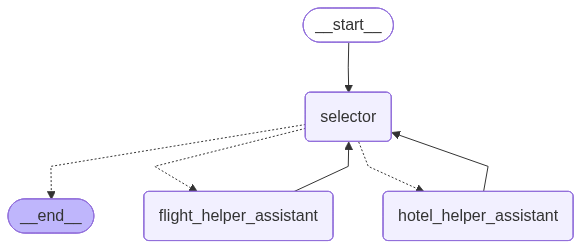

In [7]:
display(Image(app.get_graph().draw_mermaid_png()))

In [8]:
import uuid

config = {"configurable": {"thread_id": str(uuid.uuid4())}}
context = Context(user_id="1")

In [9]:
from langchain.messages import HumanMessage
response = app.invoke(
    {"messages": [HumanMessage(content="i am looking for a flight from boston to ny tomorrow")]},
    config,
    context=context
)

response['messages']

[HumanMessage(content='i am looking for a flight from boston to ny tomorrow', additional_kwargs={}, response_metadata={}, id='f902962c-a599-4ab2-91a3-1fe125ad3b24'),
 HumanMessage(content='I found a flight from Boston (BOS) to New York (JFK) for tomorrow, February 6, 2026. The flight is operated by Jet Blue. Would you like to book this flight?', additional_kwargs={}, response_metadata={}, name='flight_helper_assistant', id='bdc2220c-ee66-4f21-bc83-db64028d32dc')]